## Assisting tool for building risk strategies
---

an interfrace for solving Trust-Region Constrained Algorithm [here](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#trust-region-constrained-algorithm-method-trust-constr)

Usecase:
* we would like to see how we can minimize risk group shifts by changing the boundaries

### Optimization Method for RG Segmentations
---

Directly copied from [customer model 2021Q1 refitting](https://gitlab.com/sofiinc/data-science-risk/sofi-money-risk-models/customer-model-v1/-/blob/master/notebooks/2021Q1-refitting/9-reduce-rg-movements.ipynb)

In [14]:
import pandas as pd
from scipy.optimize import minimize, Bounds, dual_annealing

In [13]:
df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")].copy()

#### Global method: Dual Annealing

In [34]:
def get_risk_groups(serie, thresholds):
    thresh = sorted(list(set(list(thresholds)+[300, 850])))
    
    return pd.cut(serie.round(), thresh, 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)    

def risk_group_shift(rg1, rg2):
    return 1 - (rg1 == rg2).mean()

def obj_fn(thresholds):
    rg1 = df_["rg_incumbent"]
    rg2 = get_risk_groups(df_["score_wo_ind"], thresholds)
    return risk_group_shift(rg1, rg2)

In [54]:
%%time 
bounds = [[300, 500],
          [460, 560],
          [500, 600], 
          [600, 850]]
result = dual_annealing(obj_fn, bounds, maxiter=1000)

CPU times: user 1min 56s, sys: 29.8 ms, total: 1min 56s
Wall time: 1min 56s


In [55]:
result

     fun: 0.25880933299890496
 message: ['Maximum number of iteration reached']
    nfev: 8116
    nhev: 0
     nit: 1000
    njev: 23
  status: 0
 success: True
       x: array([499.12658763, 520.96006678, 565.28298415, 600.11277609])

In [56]:
obj_fn([474, 510, 560, 600])

0.28308088068859616

In [49]:
obj_fn([480, 512, 557, 600])

0.2765992915828047

In [52]:
obj_fn([500, 524, 565, 600])

0.25864568740326555

In [57]:
obj_fn([500, 520, 565, 600])

0.2584912181961667

nr accounts:  653852
ratio of users kept their RG:  0.7415087818038333


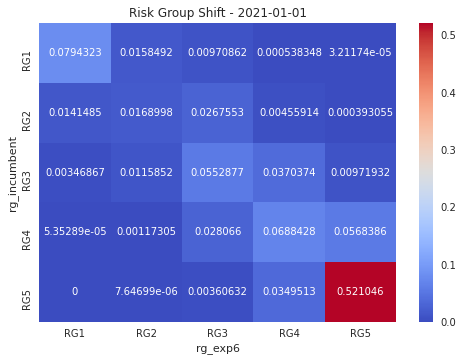

In [65]:
df_["rg_exp6"] = get_risk_groups(df_["score_wo_ind"], [500, 520, 565, 600])
get_transition_plot(df_, "rg_incumbent", "rg_exp6")

#### Local Methods

In [63]:
%%time
result = minimize(obj_fn, x0=(474, 510, 560, 600), method="Powell")

CPU times: user 3.46 s, sys: 122 µs, total: 3.46 s
Wall time: 3.46 s


In [64]:
result

   direc: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: 0.2573640518037721
 message: 'Optimization terminated successfully.'
    nfev: 237
     nit: 2
  status: 0
 success: True
       x: array([520.16010247, 508.40983005, 565.13748706, 598.40983005])

In [62]:
obj_fn([508, 520, 565, 600])

0.25740381615411434

nr accounts:  653852
ratio of users kept their RG:  0.7425961838458855


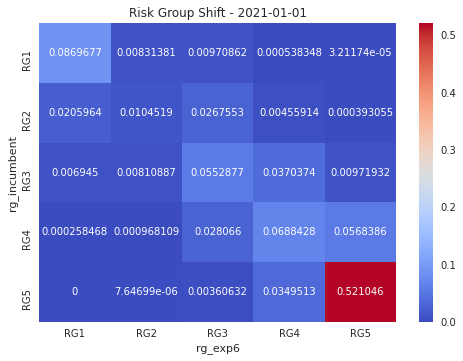

In [66]:
df_["rg_exp6"] = get_risk_groups(df_["score_wo_ind"], [508, 520, 565, 600])
get_transition_plot(df_, "rg_incumbent", "rg_exp6")